## Прогнозирование спроса
Краткое описание:
Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.

Задача:
Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных признаков.

Метрика качества:
`WAPE:
def wape(y_true: np.array, y_pred: np.array):
return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))`

- sales_df_train.csv –данные по продажам за скользящий год для обучения.
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата;
    - pr_sales_type_id – флаг наличия промо;
    - pr_sales_in_units – число проданных товаров всего (промо и без);
    - pr_promo_sales_in_units – число проданных товаров с признаком промо;
    - pr_sales_in_rub – продажи в РУБ всего (промо и без);
    - pr_promo_sales_in_rub – продажи с признаком промо в РУБ;
- pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
    - pr_group_id – захэшированная группа товара;
    - pr_cat_id – захэшированная категория товара;
    - pr_subcat_id – захэшированная подкатегория товара;
    - pr_sku_id – захэшированное id товара;
    - pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).
- pr_st.csv – данные по магазинам.
    - st_id – захэшированное id магазина;
    - st_city_id – захэшированное id города;
    - st_division_code id – захэшированное id дивизиона;
    - st_type_format_id – id формата магазина;
    - st_type_loc_id – id тип локации/окружения магазина;
    - st_type_size_id – id типа размера магазина;
    - st_is_active – флаг активного магазина на данный момент.
- sales_submission.csv – пример файла с результатом работы модели прогноза спроса.
Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата (день);
    - target – спрос в ШТ.

### Libraries

In [1]:
# !pip install phik
# !pip install catboost

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import phik
from phik.report import plot_correlation_matrix
from catboost import CatBoostRegressor, Pool
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
warnings.filterwarnings('ignore')

### EDA

In [4]:
sales_df_train = pd.read_csv('sp_sales_task/sales_df_train.csv', parse_dates=['date'])
shops = pd.read_csv('sp_sales_task/st_df.csv')
products = pd.read_csv('sp_sales_task/pr_df.csv')
holiday = pd.read_csv('holidays_covid_calendar.csv')

In [5]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


In [6]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes


In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [8]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


In [9]:
holiday = holiday[['date', 'holiday']]
holiday['date'] = pd.to_datetime(holiday['date'], format='%d.%m.%Y')

In [10]:
sales_df_train = sales_df_train.merge(holiday, on='date', how='left')
sales_df_train.sample()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,holiday
520176,16a5cdae362b8d27a1d8f8c7b78b4330,984866d32efb12f24c9ec497f3fad041,2023-01-20,0,7.0,0.0,526.0,0.0,0


Уникальное количество товаров

In [11]:
len(sales_df_train['pr_sku_id'].unique())

1991

Уникальное количество магазинов

In [12]:
len(sales_df_train['st_id'].unique())

12

Вывод: Дубликатов и пропусков не обнаружено.

#### Объединение датафреймов

Объединим данные по магазинам и товарам в одну таблицу для выведения активных магазинов

In [13]:
total = sales_df_train.merge(shops, on='st_id', how='left').merge(products, on='pr_sku_id', how='left')
index_no_active = total.index[total['st_is_active']== 0].tolist()
total = total.drop(index=index_no_active) #удаление информации по неактивным магазинам
total = total.drop(['st_is_active'], axis=1) #удаление ненужного признака (в нём осталось только одно значение)

In [14]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882286 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    882286 non-null  object        
 1   pr_sku_id                882286 non-null  object        
 2   date                     882286 non-null  datetime64[ns]
 3   pr_sales_type_id         882286 non-null  int64         
 4   pr_sales_in_units        882286 non-null  float64       
 5   pr_promo_sales_in_units  882286 non-null  float64       
 6   pr_sales_in_rub          882286 non-null  float64       
 7   pr_promo_sales_in_rub    882286 non-null  float64       
 8   holiday                  882286 non-null  int64         
 9   st_city_id               882286 non-null  object        
 10  st_division_code         882286 non-null  object        
 11  st_type_format_id        882286 non-null  int64         
 12  st_type_loc_id       

#### Нулевые значения в целевом признаке

In [15]:
sales_units_zero = total[total['pr_sales_in_units'] == 0]
display(
    'нулевые продажи в шт и руб:',
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count(),
    'их доля в данных, %:',
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] == 0]['pr_sales_in_rub'].count() / total['pr_sales_in_rub'].count() * 100, 2)
)
display(
    'нулевые продажи в шт, но не нулевые в рублях:',
    sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count(),
    'их доля в данных, %:',
    round(sales_units_zero[sales_units_zero['pr_sales_in_rub'] != 0]['pr_sales_in_rub'].count() / total['pr_sales_in_rub'].count() * 100, 2)
)

'нулевые продажи в шт и руб:'

453

'их доля в данных, %:'

0.05

'нулевые продажи в шт, но не нулевые в рублях:'

66089

'их доля в данных, %:'

7.49

В данных имеются записи, которые можно удалить (их доля 7.53%): нулевые значения в количестве проданных товаров и их стоимости

In [16]:
total = total.loc[total['pr_sales_in_units'] != 0]

#### Отрицательные значения в целевом признаке

In [17]:
display(
    'количество записей возвратов:',
    total[total['pr_sales_in_units'] < 0]['pr_sales_in_units'].count(),
    'их доля в данных, %:',
    round(total[total['pr_sales_in_units'] < 0]['pr_sales_in_units'].count() / total['pr_sales_in_units'].count() * 100, 2)
)

'количество записей возвратов:'

71

'их доля в данных, %:'

0.01

Удаление записей возврата

In [18]:
total = total.loc[total['pr_sales_in_units'] > 0]
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815673 entries, 0 to 883014
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    815673 non-null  object        
 1   pr_sku_id                815673 non-null  object        
 2   date                     815673 non-null  datetime64[ns]
 3   pr_sales_type_id         815673 non-null  int64         
 4   pr_sales_in_units        815673 non-null  float64       
 5   pr_promo_sales_in_units  815673 non-null  float64       
 6   pr_sales_in_rub          815673 non-null  float64       
 7   pr_promo_sales_in_rub    815673 non-null  float64       
 8   holiday                  815673 non-null  int64         
 9   st_city_id               815673 non-null  object        
 10  st_division_code         815673 non-null  object        
 11  st_type_format_id        815673 non-null  int64         
 12  st_type_loc_id       

#### Проанализируем целевую переменную `pr_sales_in_units`

In [19]:
total['pr_sales_in_units'].describe()

count    815673.000000
mean          5.451414
std          13.864076
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

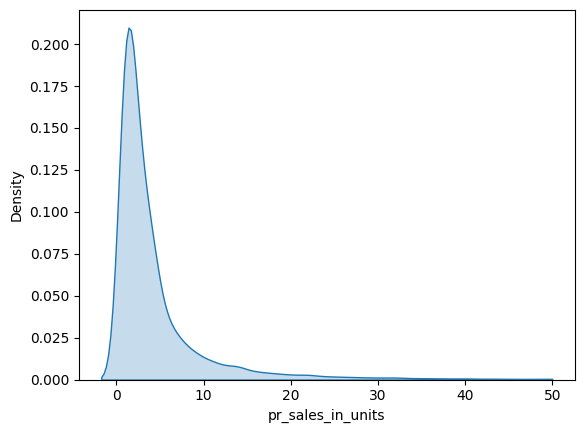

In [20]:
sns.kdeplot(total, x='pr_sales_in_units', clip=(-10, 50), fill=True);

Cреднее значение больше медианного, наблюдается правосторонняя асимметрия. Распределение целевой переменной `pr_sales_in_units` отличается от нормального.

#### Корреляция между категориальными признаками

In [21]:
categ_cols = [
    'st_id', 'pr_sales_type_id', 'st_city_id', 'st_division_code',
    'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_group_id',
    'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'pr_uom_id', 'holiday'
    ]
phik_overview = total[categ_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_type_id', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id', 'holiday']


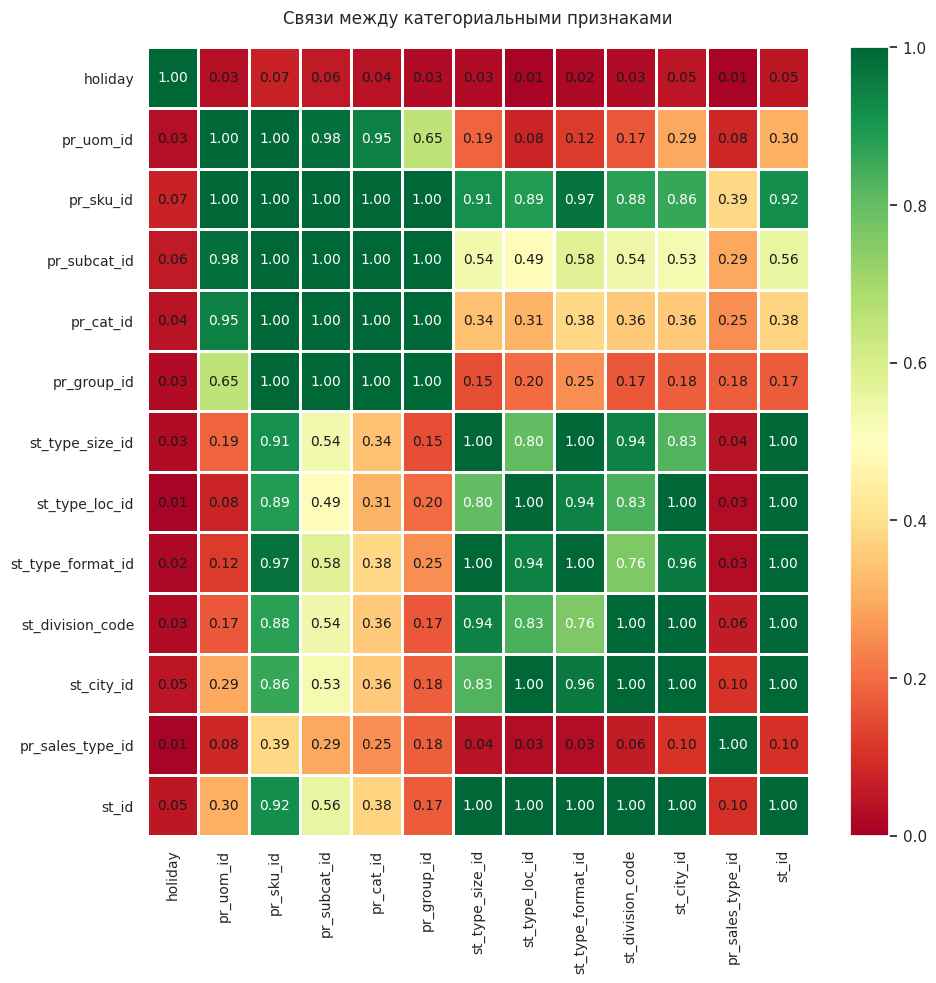

In [22]:
sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        fontsize_factor=1.0, figsize=(10, 10))

plt.title('Связи между категориальными признаками', fontsize=12, y=1.02)
plt.tight_layout()

Наблюдается сильная зависимость между категориальными признаками, что вполне логично.
Удаление зависимых признаков.

In [23]:
quant_cols = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
phik_overview_q = total[quant_cols].phik_matrix();

interval columns not set, guessing: ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']


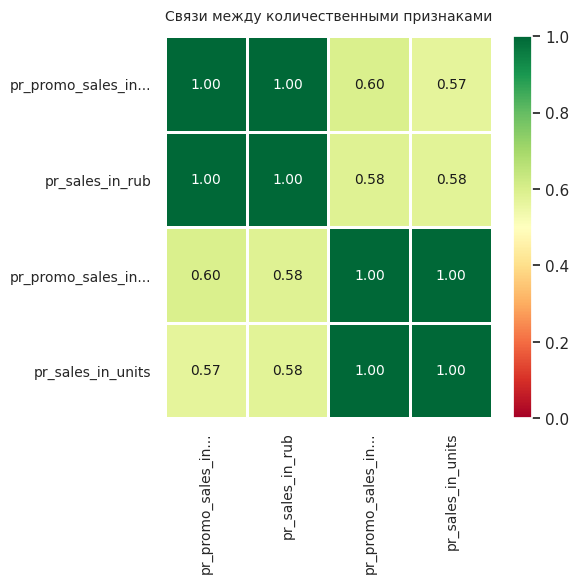

In [24]:
sns.set()
plot_correlation_matrix(phik_overview_q.values,
                        x_labels=phik_overview_q.columns,
                        y_labels=phik_overview_q.index,
                        vmin=0, vmax=1,
                        fontsize_factor=1.0, figsize=(6, 6))

plt.title('Связи между количественными признаками', fontsize=10, y=1.02)
plt.tight_layout()

Высокая корреляция наблюдается у признаков:
- Целевой признак `pr_sales_in_units` и `pr_promo_sales_in_units`
- `pr_promo_sales_in_units` и `pr_promo_sales_in_rub`
- `pr_sales_in_rub` и `pr_promo_sales_in_rub`
    
Средняя корреляция наблюдается у признаков:

- Целевой признак `pr_sales_in_units` и `pr_sales_in_rub`
- Целевой признак `pr_sales_in_units` и `pr_promo_sales_in_rub`
- `pr_promo_sales_in_units` и `pr_sales_in_rub`

Удалим сильно коррелированные столбцы

In [25]:
total = total.drop(['pr_promo_sales_in_units', 'pr_promo_sales_in_rub'], axis=1)

#### Распределение целевого признака между выходными и буднями

In [26]:
holiday_1_units = total[total['holiday'] == 1]['pr_sales_in_units'].sum()
holiday_0_units = total[total['holiday'] == 0]['pr_sales_in_units'].sum()
holiday_1_rub = total[total['holiday'] == 1]['pr_sales_in_rub'].sum()
holiday_0_rub =  total[total['holiday'] == 0]['pr_sales_in_rub'].sum()

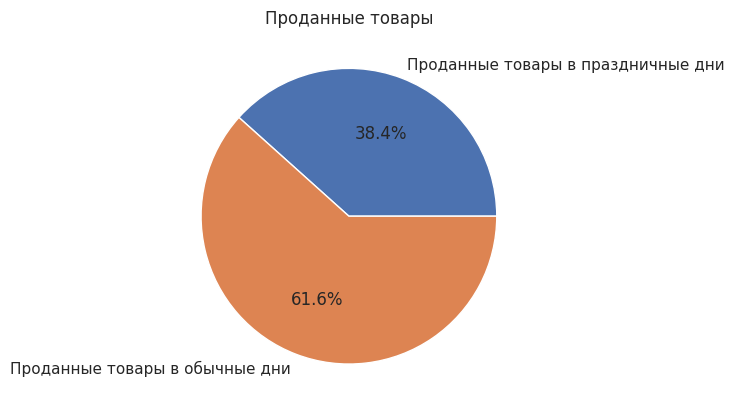

In [27]:
labels = 'Проданные товары в праздничные дни', 'Проданные товары в обычные дни'
sizes = [holiday_1_units, holiday_0_units]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Проданные товары')
plt.show()

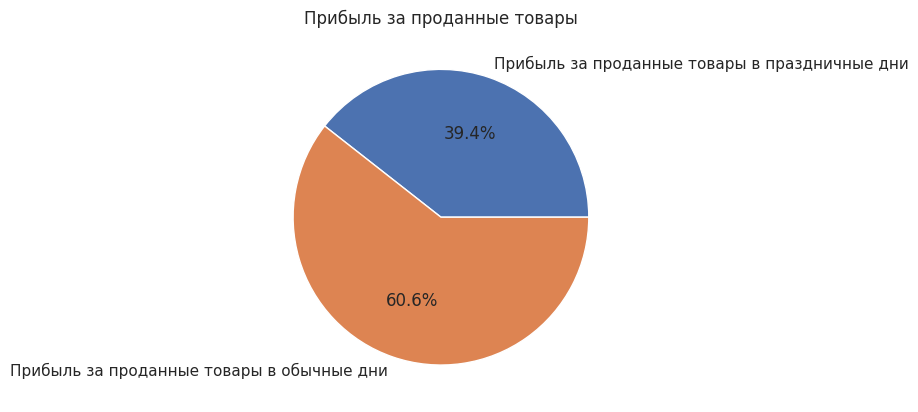

In [28]:
labels = 'Прибыль за проданные товары в праздничные дни', 'Прибыль за проданные товары в обычные дни'
sizes = [holiday_1_rub, holiday_0_rub]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Прибыль за проданные товары')
plt.show()

#### Распределение целевого признака по датам

In [29]:
total=total.set_index('date')

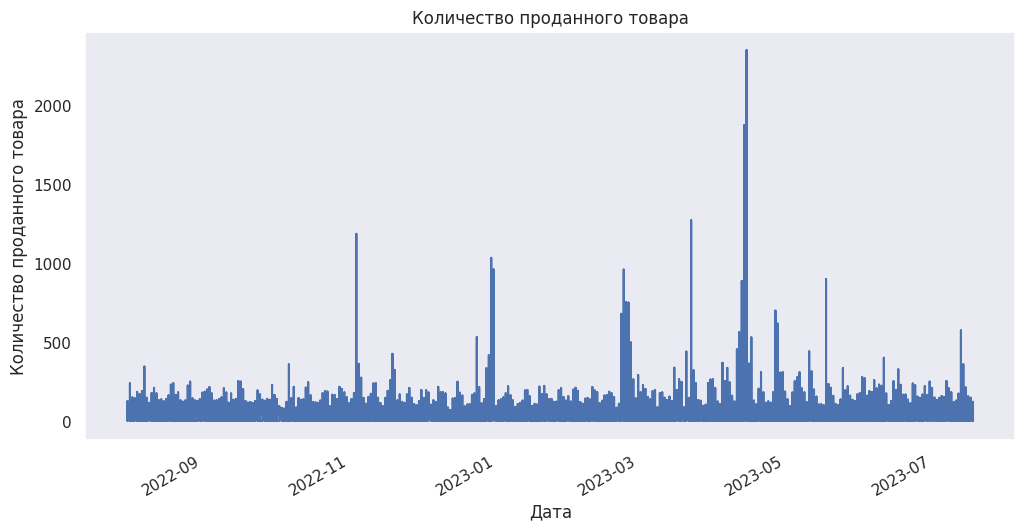

In [30]:
total['pr_sales_in_units'].plot(figsize=(12,6));
plt.title("Количество проданного товара")
plt.xlabel("Дата")
plt.ylabel("Количество проданного товара")
plt.grid();

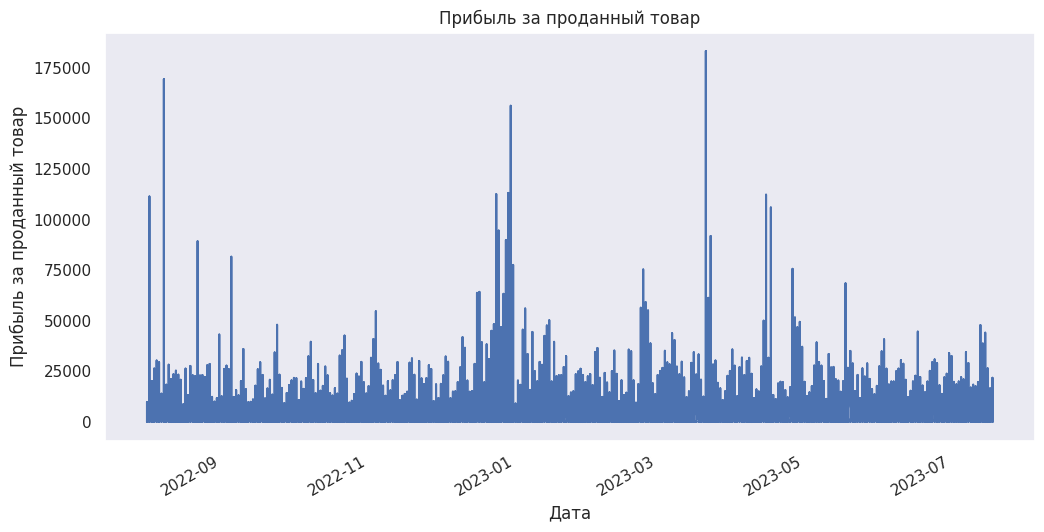

In [31]:
total['pr_sales_in_rub'].plot(figsize=(12,6));
plt.title("Прибыль за проданный товар")
plt.xlabel("Дата")
plt.ylabel("Прибыль за проданный товар")
plt.grid();

#### Скользящее среднее

In [32]:
total['mean'] = total['pr_sales_in_units'].rolling(15).mean()

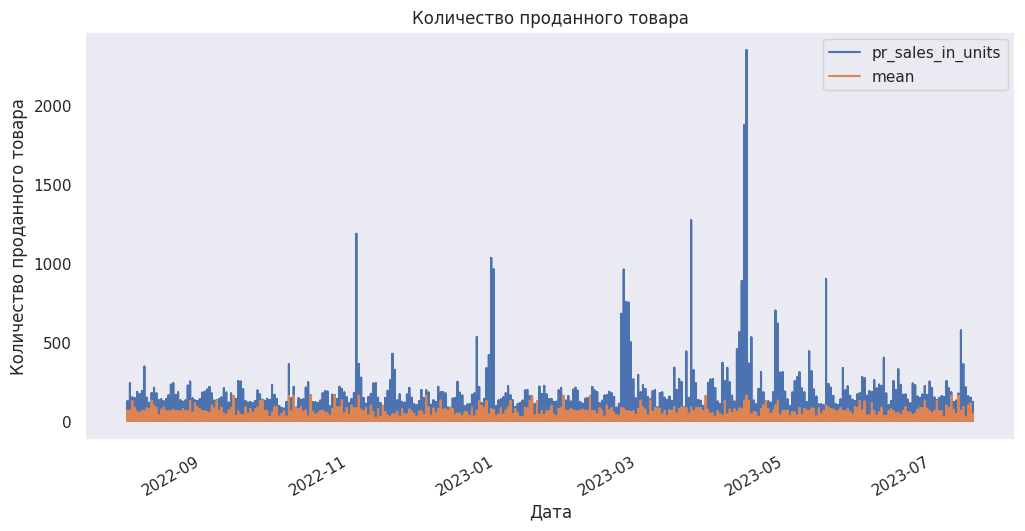

In [33]:
total['pr_sales_in_units'].plot(figsize=(12,6));
total['mean'].plot(figsize=(12,6));
plt.title("Количество проданного товара")
plt.xlabel("Дата")
plt.ylabel("Количество проданного товара")
plt.grid()
plt.legend();

In [34]:
total = total.drop(columns=['mean'])

#### Resampling по суммарным значениям за день

In [35]:
total_resamp = total.resample('1D').sum()

#### Графики среднего значения за 1 день для параметров `pr_sales_in_units`, `pr_sales_in_rub`

In [36]:
columns = ['pr_sales_in_units', 'pr_sales_in_rub']

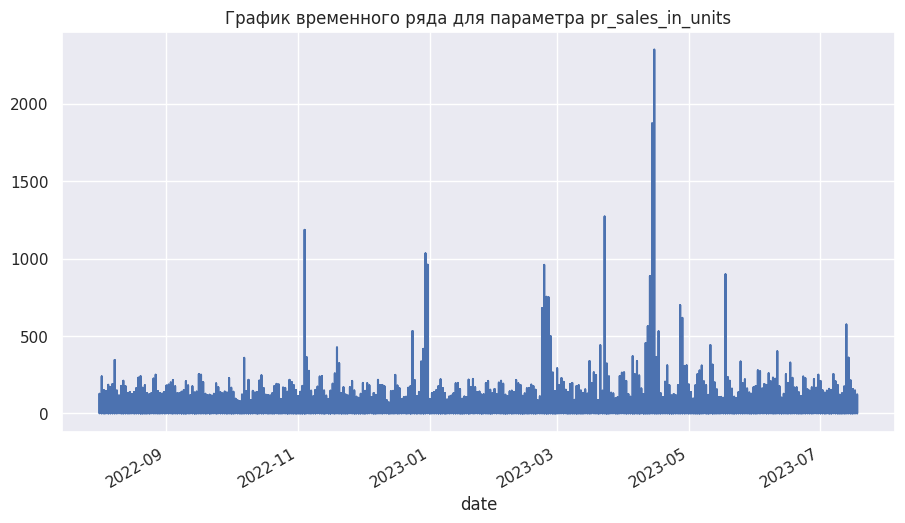

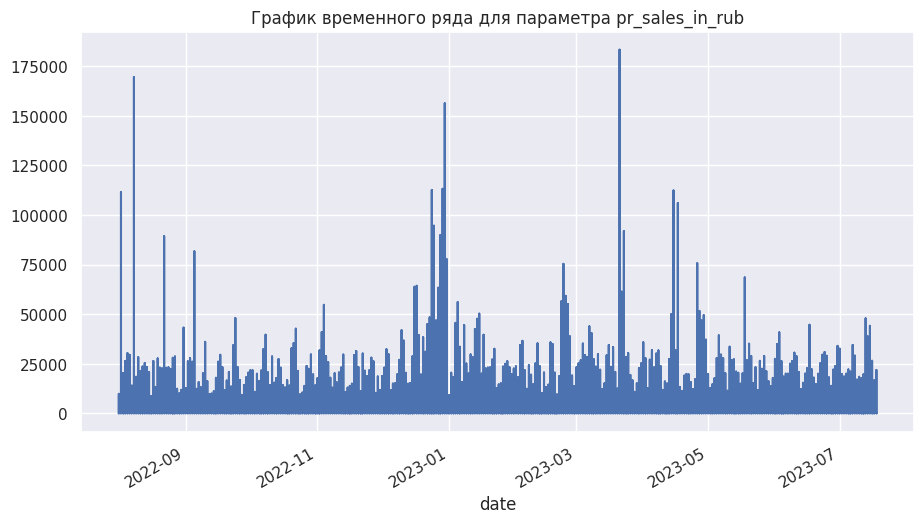

In [37]:
for num in columns:
    fig = plt.figure(figsize=(25,10))
    ax1 = fig.add_subplot(121)
    plot1 = total[num].plot(title= 'График временного ряда для параметра ' +  num)
    plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
    plt.show()

#### Графики скользящего среднего значения за 1 день для параметров `pr_sales_in_units`, `pr_sales_in_rub`

In [38]:
total['rolling_mean_units'] = total['pr_sales_in_units'].rolling(10).mean()
total['rolling_mean_rub'] = total['pr_sales_in_rub'].rolling(10).mean()

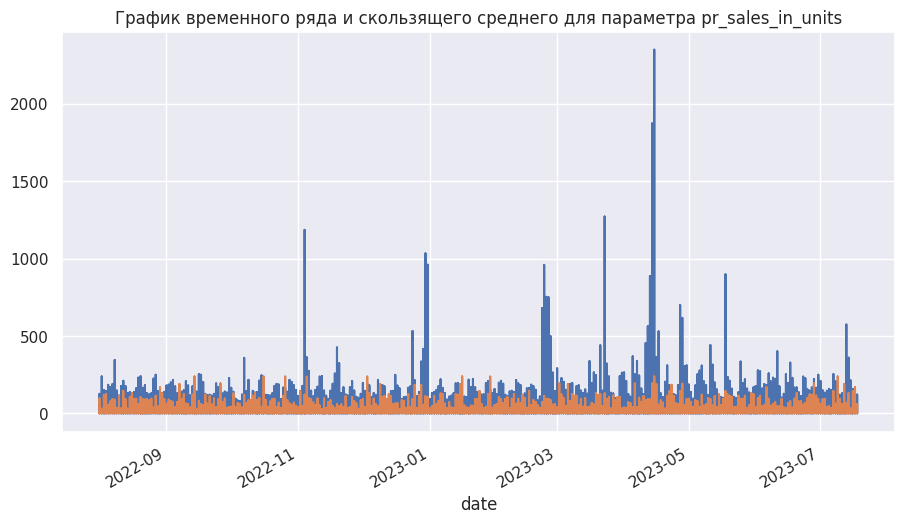

In [39]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plot1 = total['pr_sales_in_units'].plot(title= 'График временного ряда и скользящего среднего для параметра pr_sales_in_units')
plot2 = total['rolling_mean_units'].plot()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
plt.show()

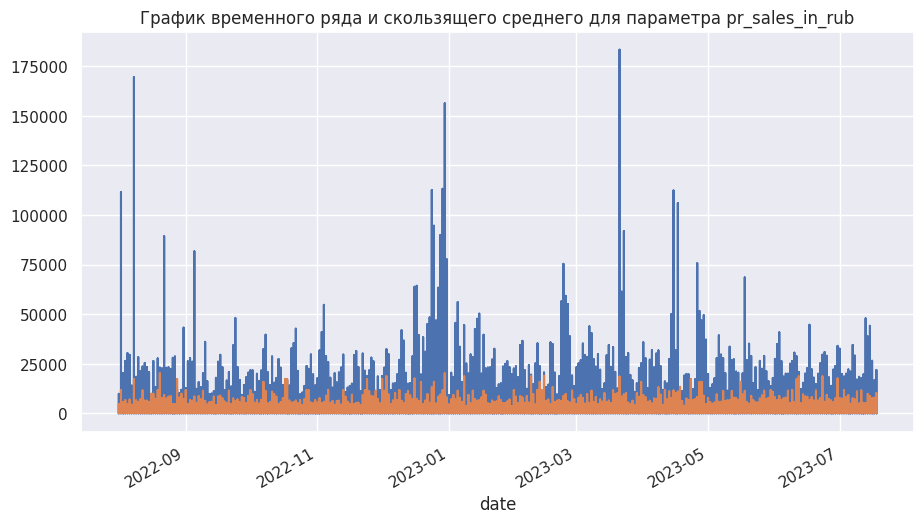

In [40]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plot1 = total['pr_sales_in_rub'].plot(title= 'График временного ряда и скользящего среднего для параметра pr_sales_in_rub')
plot2 = total['rolling_mean_rub'].plot()
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
plt.show()

#### Изучение сезонности

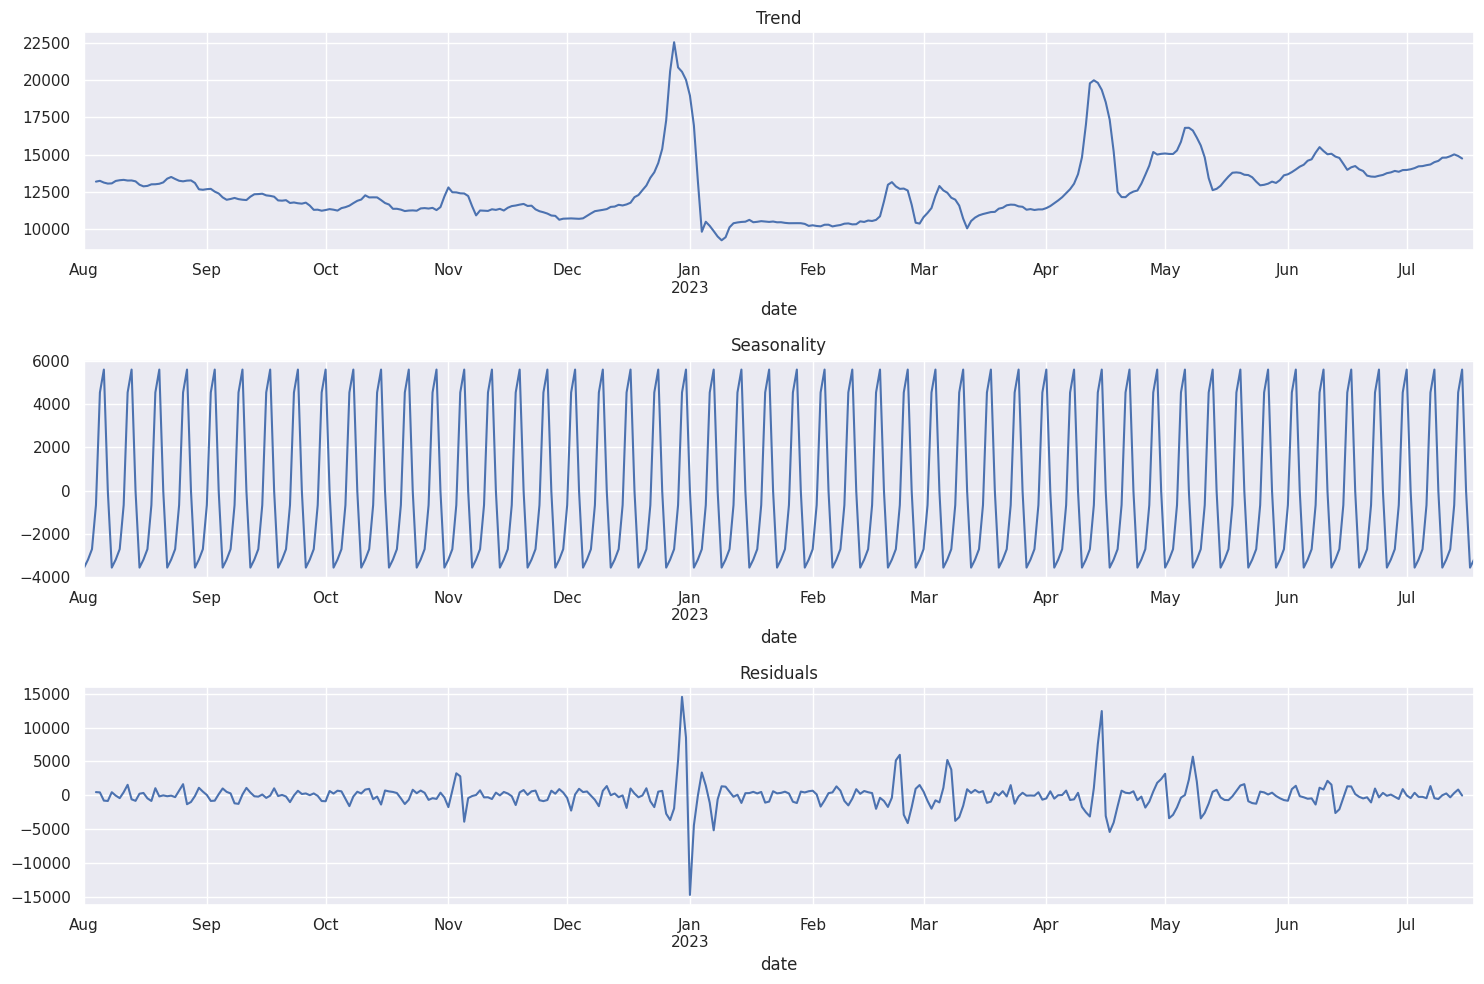

In [41]:
decomposed_units = seasonal_decompose(total_resamp['pr_sales_in_units'])

plt.figure(figsize=(15,10))
plt.subplot(311)

decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

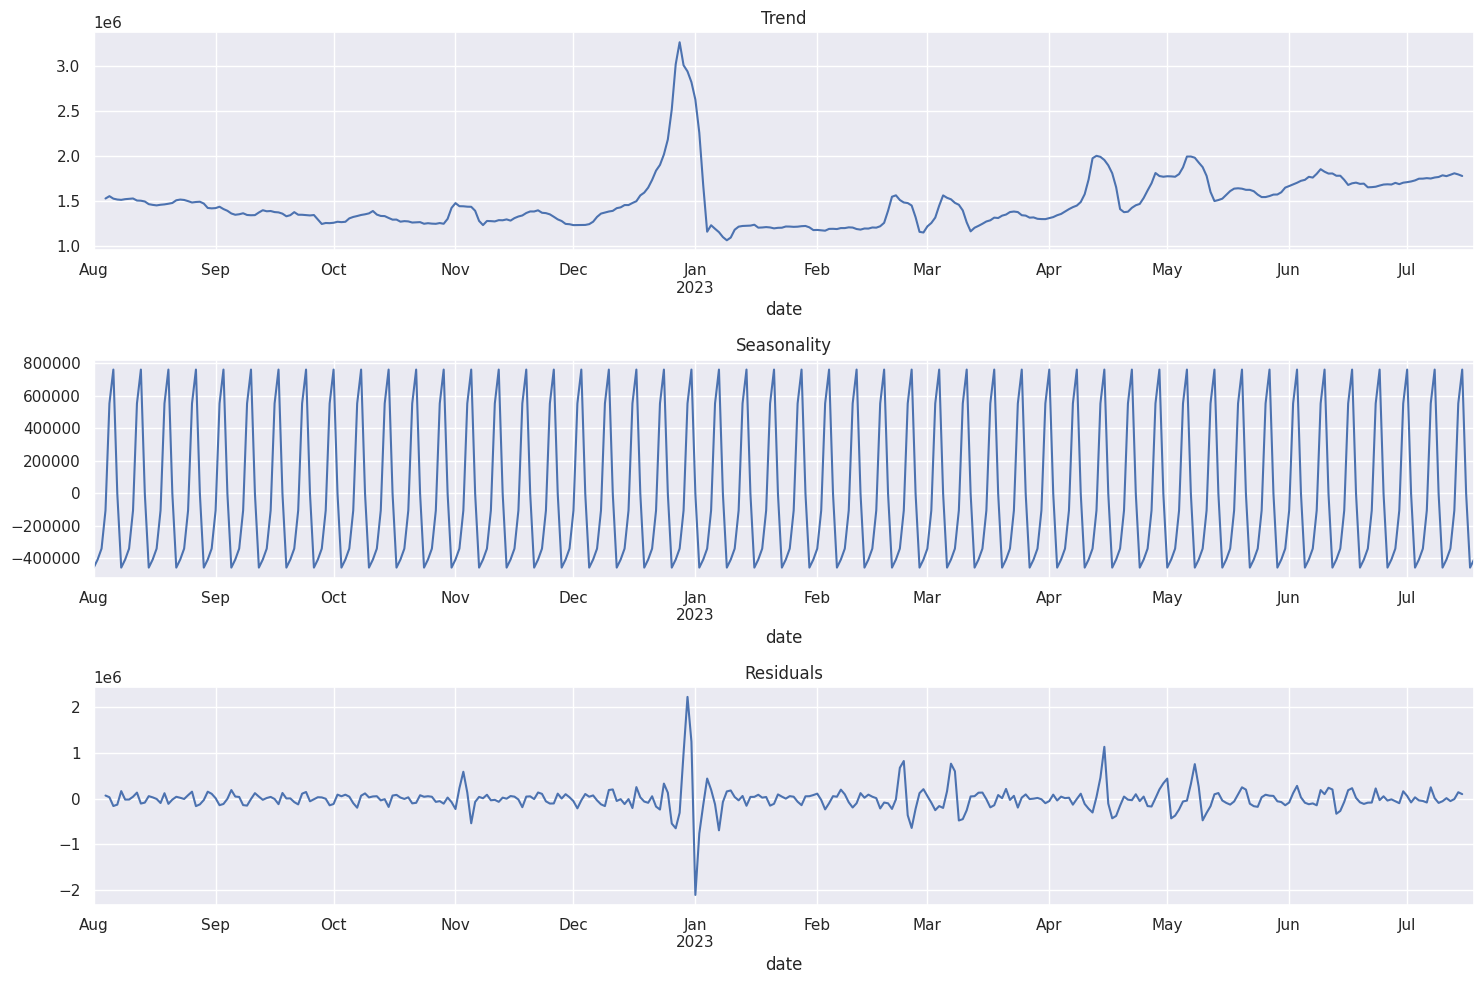

In [42]:
decomposed_rub = seasonal_decompose(total_resamp['pr_sales_in_rub'])

plt.figure(figsize=(15,10))
plt.subplot(311)

decomposed_rub.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_rub.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_rub.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

#### Сезоннось и тренд за две недели

In [43]:
data_week = total_resamp['pr_sales_in_rub']
data_week = data_week['2023-06-24':'2023-07-11']

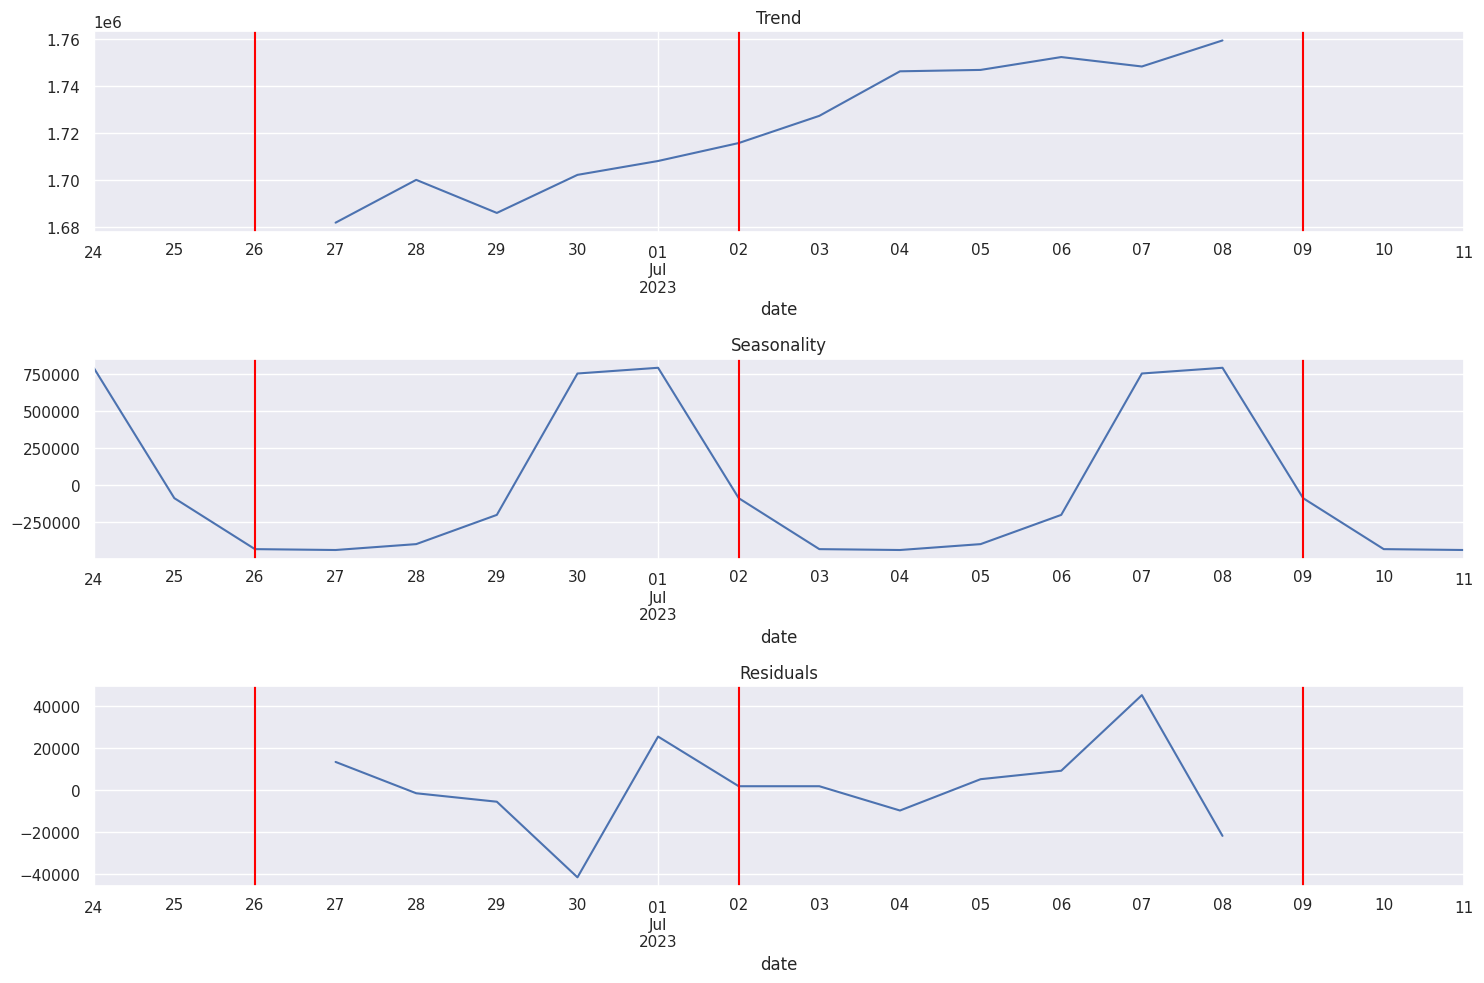

In [44]:
decomposed_week = seasonal_decompose(data_week)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')

plt.title('Trend')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')

plt.title('Seasonality')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Residuals')
plt.tight_layout()
plt.show()

In [45]:
data_week_1 = total_resamp['pr_sales_in_rub']
data_week_1 = data_week_1['2023-04-02':'2023-04-17']

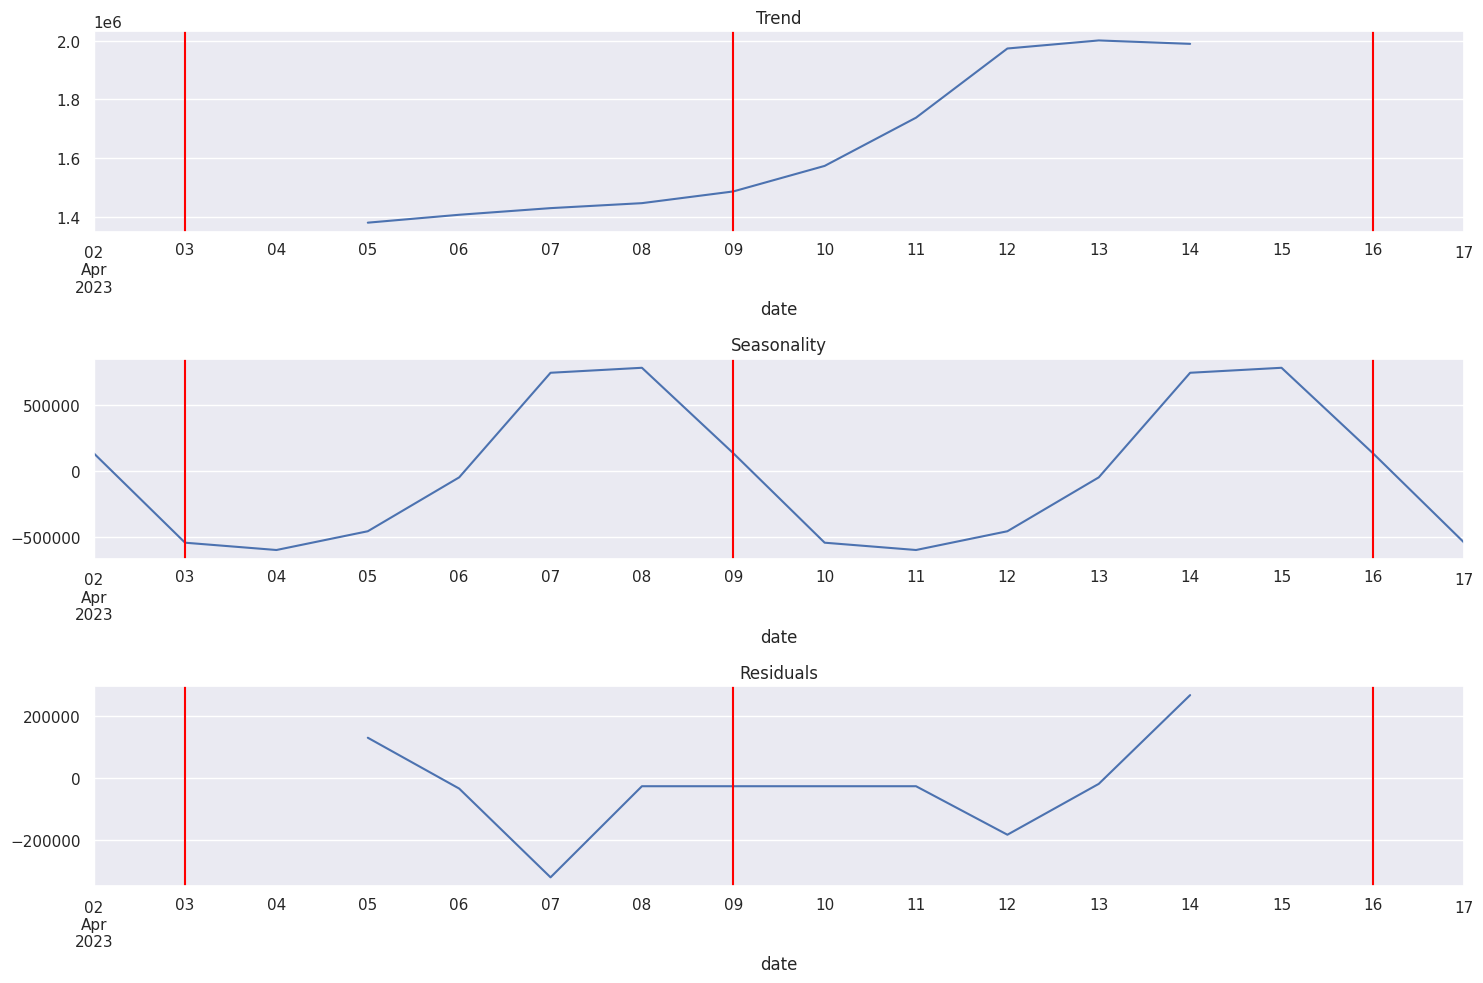

In [46]:
decomposed_week_1 = seasonal_decompose(data_week_1)

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed_week_1.trend.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Trend')

plt.subplot(312)
decomposed_week_1.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Seasonality')

plt.subplot(313)
decomposed_week_1.resid.plot(ax=plt.gca())
plt.axvline(x='2023-04-03', color='red', label='axvline - full height')
plt.axvline(x='2023-04-09', color='red', label='axvline - full height')
plt.axvline(x='2023-04-16', color='red', label='axvline - full height')
plt.title('Residuals')
plt.tight_layout()
plt.show()

**Вывод:**
- На графике тренда видим, что продажи растут в дни государственных праздников: Новый год, 23 февраля, 8 марта, майские праздники, 12 июня.
- Так же летом продажи выше, чем в остальные времена года.
- Продажи резко растут в пятницу и субботу, в воскресенье начинают падать в течении недели спрос маленький. Клиенты чаще совершают покупки перед выходными днями и в выходные.

#### Проверка на стационарность

In [47]:
p_value = adfuller(total_resamp['pr_sales_in_units'])[1]
print('p =', p_value)
if p_value < 0.05:
    display('Нулевая гипотеза отвергается. Ряд стационарен по расширеннему тесту Дики-Фуллера')
else:
    display('Нулевая гипотеза не отвергается. Ряд нестационарен по расширеннему тесту Дики-Фуллера')

p = 0.014722641217042629


'Нулевая гипотеза отвергается. Ряд стационарен по расширеннему тесту Дики-Фуллера'

#### Выводы
- Данные предоставлены за период с 01.08.2022 по 18.07.2023
- Предоставленные датасеты объединены в один датафрейм
- К общему датафрейму добавлена информация о государственных праздниках и выходных днях в РФ
- Удалены записи по магазинам без маркера активности (действие согласовано с бизнесом): им соответствует 729 записей, что составляет 0.08% датасета.
- Распределение целевой переменной `pr_sales_in_units` отличается от нормального: наблюдается правосторонняя асимметрия
- Удалены данные с нулевыми продажами в шт и руб.
- Удалены записи с отрицательным значением целевого признака (действие согласовано с бизнесом)
- Удалены сильно коррелированные признаки
- Данные разложены на три составляющие (для этого осуществлён ресемплинг по одному дню) - сезонность, тренд и остаток:
  - наблюдается рост спроса перед праздничными днями (годовая сезонность)
  - рост спроса в выходные дни (недельная сезонность)
- Временной ряд стационарен, о чём свидетельствует тест Дики-Фуллера

### Feature engineering

#### Удаление признака `pr_sales_type_id`

In [48]:
total = total.drop(['pr_sales_type_id'], axis=1)

Данный признак (продажа с промо или без) не несёт полезной информации, т.к. прогнозируется общее количество спроса

#### Удаление пропущенных значений

Удаление возможных пропусков и сортировка по дате

In [49]:
total = total.dropna()
total = total.sort_values(by='date')

#### Добавление новых признаков

In [50]:
total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 815664 entries, 2022-08-01 to 2023-07-18
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   st_id               815664 non-null  object 
 1   pr_sku_id           815664 non-null  object 
 2   pr_sales_in_units   815664 non-null  float64
 3   pr_sales_in_rub     815664 non-null  float64
 4   holiday             815664 non-null  int64  
 5   st_city_id          815664 non-null  object 
 6   st_division_code    815664 non-null  object 
 7   st_type_format_id   815664 non-null  int64  
 8   st_type_loc_id      815664 non-null  int64  
 9   st_type_size_id     815664 non-null  int64  
 10  pr_group_id         815664 non-null  object 
 11  pr_cat_id           815664 non-null  object 
 12  pr_subcat_id        815664 non-null  object 
 13  pr_uom_id           815664 non-null  int64  
 14  rolling_mean_units  815664 non-null  float64
 15  rolling_mean_rub  

In [52]:
total['day'] = total.index

In [55]:
total['month'] = total['day'].dt.month
total['year'] = total['day'].dt.year
total['weekday'] = total['day'].dt.weekday
total['dt'] = total['day']
total['day'] = total['dt'].dt.day
total.head(5)

,st_id,pr_sku_id,pr_sales_in_units,pr_sales_in_rub,holiday,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,...,pr_cat_id,pr_subcat_id,pr_uom_id,rolling_mean_units,rolling_mean_rub,day,month,year,weekday,dt
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,49a2be29ab4977d11ce510b2810c3fdb,2.0,259.0,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,...,9701a1c165dd9420816bfec5edd6c2b1,8afe22eeb3f3f68de994a3c60388858c,1,4.6,809.1,1,8,2022,0,2022-08-01
2022-08-01,6364d3f0f495b6ab9dcf8d3b5c6e0b01,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2.0,445.0,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,...,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,1,5.1,557.1,1,8,2022,0,2022-08-01
2022-08-01,42a0e188f5033bc65bf8d78622277c4e,b960c6ee5b5efa12e73f810204b561a8,1.0,57.0,0,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,...,c559da2ba967eb820766939a658022c8,8ec316a6bd7240d74c0567a1d9b311e5,17,4.5,601.7,1,8,2022,0,2022-08-01
2022-08-01,f7e6c85504ce6e82442c770f7c8606f0,566f6537c25d40d0b6adec07323e65e8,3.0,83.0,0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,...,c559da2ba967eb820766939a658022c8,89b0107c6d0aca5f15fa7a715f9e06e5,17,5.7,567.9,1,8,2022,0,2022-08-01
2022-08-01,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ee441af33a59b66a2026b029a24f269a,12.0,1332.0,0,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,...,e58cc5ca94270acaceed13bc82dfedf7,120e4b609af49ff7b17c3b90e7a28435,1,8.1,547.7,1,8,2022,0,2022-08-01


#### Выделение категориальных и количественных признаков

In [62]:
RS = 42
#возможно, нужно восстановить признак pr_sales_type_id
#категориальные признаки-числа: 'holiday', 'st_type_format_id', 'st_type_loc_id', 'st_type_size_id', 'pr_uom_id'
#cat_features = ['st_type_format_id', 'st_type_loc_id', 'st_division_code', 'st_type_size_id', 'st_id', 'pr_sku_id']#, 'st_city_id', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_uom_id']
num_features = ['rolling_mean_units', 'rolling_mean_rub', 'holiday']
cat_features = ['st_id', 'pr_sku_id']

In [63]:
len(total['st_id'].unique()) #10 +
len(total['pr_sku_id'].unique()) #1972 +
len(total['holiday'].unique()) #2 +
len(total['st_city_id'].unique()) #6
len(total['st_division_code'].unique()) #5 +
len(total['st_type_format_id'].unique()) #3 +
len(total['st_type_loc_id'].unique()) #3 +
len(total['st_type_size_id'].unique()) #5 +
len(total['pr_group_id'].unique()) #9
len(total['pr_cat_id'].unique()) #43
len(total['pr_subcat_id'].unique()) #165
len(total['pr_uom_id'].unique()) #2
total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 815664 entries, 2022-08-01 to 2023-07-18
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   st_id               815664 non-null  object        
 1   pr_sku_id           815664 non-null  object        
 2   pr_sales_in_units   815664 non-null  float64       
 3   pr_sales_in_rub     815664 non-null  float64       
 4   holiday             815664 non-null  int64         
 5   st_city_id          815664 non-null  object        
 6   st_division_code    815664 non-null  object        
 7   st_type_format_id   815664 non-null  int64         
 8   st_type_loc_id      815664 non-null  int64         
 9   st_type_size_id     815664 non-null  int64         
 10  pr_group_id         815664 non-null  object        
 11  pr_cat_id           815664 non-null  object        
 12  pr_subcat_id        815664 non-null  object        
 13  pr_uom_id    

Выделены категориальные признаки, установлен `random state`, проверено количество уникальных значений в каждом признаке

#### Разделение данных на обучающую и тестовую выборки

In [56]:
X = total.drop(['pr_sales_in_units', 'pr_sales_in_rub',
                'st_city_id', 'pr_group_id', 'pr_cat_id',
                'pr_subcat_id', 'pr_uom_id', 'dt'], axis=1)
y = total['pr_sales_in_units']

In [57]:
X_exp = X.drop(['holiday', 'st_division_code',	'st_type_format_id',	'st_type_loc_id',	'st_type_size_id',	'rolling_mean_units',	'rolling_mean_rub'], axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_exp, y, shuffle=False, test_size=.1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((734097, 6), (81567, 6), (734097,), (81567,))

Выделен целевой признак, удалены признаки с большим количеством уникальных значений (вынужденная мера в целях сохранения производительности)

#### Применение `OneHotEncoder` и `StandardScaler`

Использование техник кодирования и масштабирования, чтобы привести данные к виду, подходящему для обучения линейной модели

In [ ]:
# def data_encoding(X_train, X_test):
#     encoder = OrdinalEncoder()
#     encoder.fit(X_train[cat_features])

#     X_train_oe = pd.DataFrame(encoder.transform(X_train[cat_features]), columns=cat_features, index=X_train.index)
#     X_test_oe = pd.DataFrame(encoder.transform(X_test[cat_features]), columns=cat_features, index=X_test.index)
#     X_test_oe = X_test_oe.merge(X_test.drop(cat_features, axis=1), how='left', left_index=True, right_index=True, sort=False)

#     scaler = StandardScaler()
#     scaler.fit(X_train[num_features])

#     X_train_sc = pd.DataFrame(scaler.transform(X_train[num_features]), columns=num_features, index=X_train.index)
#     X_test_sc = pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features, index=X_test.index)

#     X_train_enc = X_train_oe.merge(X_train_sc, how='left', left_index=True, right_index=True, sort=False)
#     X_test_enc = X_test_oe.merge(X_test_sc, how='left', left_index=True, right_index=True, sort=False)

#     return X_train_enc, X_test_enc

In [ ]:
# X_train_enc, X_test_enc = data_encoding(X_train, X_test)
# X_train_enc.shape, X_test_enc.shape
# X_train_enc, X_test_sc = data_encoding(X_train, X_test)
# X_train_enc.sample()
# X_test_sc.sample()

При попытке кодирования данных происходит падение ядра. Проведение операции на данном этапе осложнено

### Modeling

#### Кросс-валидатор временных рядов

In [59]:
tscv = TimeSeriesSplit(n_splits=round((X_train.shape[0] / X_test.shape[0]) - 1))

#### Метрика для определения качества модели

In [60]:
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

#### Модель `CatBoostRegressor`

In [64]:
#model_cbr = CatBoostRegressor(params_cb, random_state=RS, verbose=100)
model_cbr = CatBoostRegressor(depth=7, l2_leaf_reg=2, learning_rate=0.01, iterations=1000, random_state=RS, verbose=100)
# params_cb = {'depth':[7],
#              'l2_leaf_reg': [2],
#              'learning_rate': [0.01]}#, #np.arange(0.01)
#              #'iterations': [1000]} #n_estimators
model_cbr.fit(X_train, y_train, cat_features=cat_features)

# # cbc_gs = model_cbc.grid_search(params_cb, Pool(X_train, y_train, cat_features=cat_features), cv=tscv, verbose=100)
# cbc_gs = GridSearchCV(model_cbr, params_cb, n_jobs=-1, scoring=make_scorer(wape, greater_is_better=False), cv=tscv)
# cbc_gs.fit(X_train, y_train, cat_features=cat_features)
# # display('Лучшие параметры:', model_cbc.get_params())
# display('Параметры лучшей модели', cbc_gs.best_params_)
# display('Показатель wape лучшей модели', cbc_gs.best_score_*(-1))

0:	learn: 13.9827328	total: 381ms	remaining: 6m 20s
100:	learn: 12.8106559	total: 18.6s	remaining: 2m 46s
200:	learn: 12.3660972	total: 34.8s	remaining: 2m 18s
300:	learn: 12.1551511	total: 49.8s	remaining: 1m 55s
400:	learn: 11.9650112	total: 1m 6s	remaining: 1m 39s
500:	learn: 11.7896549	total: 1m 25s	remaining: 1m 25s
600:	learn: 11.6557903	total: 1m 44s	remaining: 1m 9s
700:	learn: 11.5556662	total: 2m 4s	remaining: 53.1s
800:	learn: 11.4555227	total: 2m 25s	remaining: 36.1s
900:	learn: 11.3818119	total: 2m 45s	remaining: 18.2s
999:	learn: 11.3193420	total: 3m 6s	remaining: 0us


#### Проверка по метрике качества на тестовых данных

In [65]:
#wape(y_test, model_cbc.predict(X_test))
'Показатель wape лучшей модели на тестовой выборке', wape(y_test, model_cbr.predict(X_test))

('Показатель wape лучшей модели на тестовой выборке', 0.6791812168213021)

#### Feature importance

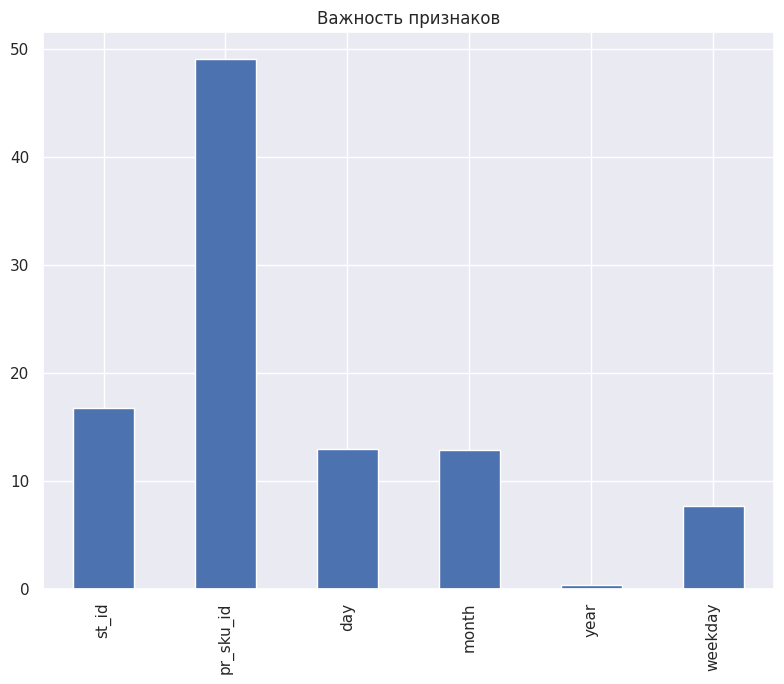

In [67]:
cbr_fi = pd.Series(model_cbr.get_feature_importance(), X_exp.columns)
fig, ax = plt.subplots(figsize=(8,7))
cbr_fi.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

#### Получение предсказания на следующие две недели

In [69]:
sales_submission = pd.read_csv('sp_sales_task/sales_submission.csv', parse_dates=['date'])
# sales_submission = sales_submission.set_index('date')
# sales_submission = sales_submission.drop('target', axis=1)
# sales_submission.tail()

In [71]:
sales_submission =  sales_submission.merge(holiday, on='date', how='left')
sales_submission.sample()

,st_id,pr_sku_id,date,target,holiday_x,holiday_y
26862,c81e728d9d4c2f636f067f89cc14862c,5a106bc85bf017f97a9afcda66b93f01,2023-07-19,0,0,0


In [73]:
sales_submission['day'] = sales_submission['date'].dt.day
sales_submission['month'] = sales_submission['date'].dt.month
sales_submission['year'] = sales_submission['date'].dt.year
sales_submission['weekday'] = sales_submission['date'].dt.weekday
sales_submission = sales_submission.drop(['holiday_y'], axis=1)
sales_submission = sales_submission.set_index('date')
sales_submission.head(5)

,st_id,pr_sku_id,target,holiday_x,day,month,year,weekday
date,,,,,,,,
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,0,0,20,7,2023,3
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,0,0,20,7,2023,3
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,0,0,20,7,2023,3
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,0,0,20,7,2023,3
2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,0,0,20,7,2023,3


In [74]:
y_pred = model_cbr.predict(sales_submission)
y_pred

array([3.01628312, 2.13329239, 6.92279583, ..., 7.16691834, 2.33883937,
       1.17647486])

In [75]:
sales_submission['target'] = y_pred
sales_submission = sales_submission.reset_index()
sales_submission.head()

,date,st_id,pr_sku_id,target,holiday_x,day,month,year,weekday
0,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,3.016283,0,20,7,2023,3
1,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2.133292,0,20,7,2023,3
2,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,6.922796,0,20,7,2023,3
3,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,1.457174,0,20,7,2023,3
4,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,6.926579,0,20,7,2023,3


In [76]:
sales_submission['target'] = round(sales_submission['target'], 0)
sales_submission.head()

,date,st_id,pr_sku_id,target,holiday_x,day,month,year,weekday
0,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,3.0,0,20,7,2023,3
1,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2.0,0,20,7,2023,3
2,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,7.0,0,20,7,2023,3
3,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,1.0,0,20,7,2023,3
4,2023-07-20,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,7.0,0,20,7,2023,3


In [78]:
sales_submission = sales_submission.drop(['holiday_x', 'day', 'month', 'year', 'weekday'], axis=1)

KeyError: ('st_id', 'pr_sku_id', 'date', 'target')

In [83]:
sales_submission = sales_submission[['st_id', 'pr_sku_id', 'date', 'target']]
sales_submission.sample()

,st_id,pr_sku_id,date,target
33343,c81e728d9d4c2f636f067f89cc14862c,c68cce0f709db5a976ee5324bbdaec98,2023-07-29,2.0


#### Сохранение результатов

Сохранение результата предсказания

In [84]:
sales_submission.to_csv('sales_submission_pred.csv', encoding='utf-8')

Запись модели в файл

In [ ]:
with open('model_cbr.pkl', 'wb') as f:
  pickle.dump(model_cbr, f)

### Заключение

- Предоставленные данные объединены в единый датафрейм, к ним присоединена информация о праздничных и выходных днях в РФ
- Проведено исследование на корреляцию в признаках, удалены зависимые признаки
- Проведено исследование на сезонность и тренд
- Возникли проблемы при попытке применения техник кодирования, в связи с чем из исследования исключены простые модели ML: линейная регрессия, случайный лес, дерево решений
- Для запуска `ARIMA` недостаточно ресурсов
- Для прогнозирования применена модель градиентного бустинга, т.к. она может одинаково хорошо работает с категориальными и количественными признаками
- При помощи `GridSearch` подобраны оптимальные параметры модели с показателем `wape` на трейне 0.63
- На тестовой выборке показатель `wape` получен 0.59
- Анализ значимости признаков показал, что наиболее важный признак - `roller_means_units` и `pr_sku_id`